# Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import os
import random
import re
import pandas as pd
import torch.nn.functional as F
import matplotlib
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.corpus import stopwords
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from collections import Counter

from torch.optim import AdamW
from Data import data_processing as dp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from AdvancedNet.lstm_analysis import analyze_lstm_performance
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.autonotebook import tqdm
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Prepare Data for PyTorch Model:
* Retrieve training, validation, and test datasets using `get_training_validation_test_data`.
* Convert the features to PyTorch tensors (type `float32`).
    - If the features are 2D, unsqueeze to add a sequence dimension.
* Convert the target labels to PyTorch tensors (type `long`).
* Organize training data into a `TensorDataset` for managing features and labels together.
* Use `DataLoader` to load the dataset in batches of size 64 with shuffling enabled for robust training.

In [2]:
# For reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# Hyperparameters
vocab_size = 12_000
embedding_dim = 100
hidden_dim = 64
n_layers = 2
seq_len = 18
learning_rate = 0.00025
max_epochs = 10
batch_size = 32

In [4]:
dataset = pd.read_csv('../Data/train.csv')
train_ds, test_ds = train_test_split(dataset, test_size=0.25, random_state=seed)

test_ds_ids = test_ds['id']

train_ds.shape, test_ds.shape


((15600, 5), (5200, 5))

In [5]:
# Handling missing values in the title column
train_ds["title"] = train_ds["title"].fillna("")
test_ds["title"] = test_ds["title"].fillna("")

# Use only the "title" column as the new feature
train_ds["new_text"] = train_ds["title"]
test_ds["new_text"] = test_ds["title"]

In [6]:
dataset = train_ds.sample(frac=1).reset_index(drop=True)

train = dataset[:int(0.95 * len(dataset))]
val = dataset[int(0.95 * len(dataset)):]
test = test_ds

# check the length of 95 percentile of the train data
train_lengths = train['title'].apply(lambda x: len(x.split()))
print("Mean length:", train_lengths.mean())
print("95th percentile:", train_lengths.quantile(0.95))



train.shape, val.shape, test.shape


Mean length: 12.094399460188933
95th percentile: 18.0


((14820, 6), (780, 6), (5200, 6))

In [7]:
def calculate_vocab_size(data, coverage=0.80):
    """
    Calculate the vocabulary size based on the desired coverage of word frequency.
    """
    all_words = [word for text in data for word in text.split()]
    word_counts = Counter(all_words)
    counts = np.array(list(word_counts.values()))
    sorted_counts = np.sort(counts)[::-1]
    cumsum = np.cumsum(sorted_counts) / sum(sorted_counts)
    vocab_size = np.argmax(cumsum >= coverage) + 1

    return vocab_size

titles = train['title'].tolist()
vocab_size_95 = calculate_vocab_size(titles, coverage=0.80)
print(f"To cover 80% of the frequency, you need {vocab_size_95} words.")



To cover 80% of the frequency, you need 5847 words.


In [8]:
def build_vocabulary():
    # Use the "title" column as the text source
    train_iterator = list(zip(train['title'], train['label']))
    tokenizer = get_tokenizer("basic_english")

    def tokenizer_fn(data_iterator):
        for text, _ in data_iterator:
            yield tokenizer(text)

    vocab = build_vocab_from_iterator(
        tokenizer_fn(train_iterator),
        specials=["<unk>"],
        max_tokens=vocab_size)
    vocab.set_default_index(vocab["<unk>"])

    return vocab, tokenizer


def clean_text(dataframe):
    stop_words = list(set(stopwords.words('english')))

    def _process_text(text):
        text = text.lower()
        text = " ".join([word for word in text.split() if word not in stop_words])
        text = re.sub(r"[^\w\s]", '', text)
        return text

    # Apply cleaning only to the "title" column
    dataframe['title'] = dataframe['title'].apply(_process_text)

    return dataframe


def tokenize_text(dataframe, vocab, tokenizer):
    # Tokenize the "title" column
    dataframe["title"] = dataframe["title"].apply(lambda x: np.array(vocab(tokenizer(x)), dtype=np.int64))
    if "label" in dataframe.columns:
        return dataframe[['title', 'label']]
    return dataframe[['title']]


def pad_tokens(dataframe, vocab, max_len):
    # Pad tokens in the "title" column
    dataframe['title'] = dataframe['title'].apply(
        lambda x: np.pad(x, (0, max(0, max_len - len(x))), 'constant', constant_values=vocab["<unk>"]))
    dataframe["title"] = dataframe["title"].apply(
        lambda x: x[:max_len])
    return dataframe


def create_dataloader(dataframe, vocab, tokenizer, seq_len, batch_size):
    dataframe = clean_text(dataframe)  # Clean the "title" column
    dataframe = tokenize_text(dataframe, vocab, tokenizer)  # Tokenize the "title" column
    dataframe = pad_tokens(dataframe=dataframe, vocab=vocab, max_len=seq_len)  # Pad tokens in the "title" column

    # Create dataset
    if "label" in dataframe.columns:
        dataset = TensorDataset(
            torch.from_numpy(np.vstack(dataframe["title"].values)),
            torch.from_numpy(dataframe["label"].values)
        )
    else:
        dataset = TensorDataset(
            torch.from_numpy(np.vstack(dataframe["title"].values))
        )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4
    )


In [9]:
vocab, tokenizer = build_vocabulary()



In [10]:

train_dataloader = create_dataloader(
    dataframe=train,
    vocab=vocab,
    tokenizer=tokenizer,
    seq_len=seq_len,
    batch_size=batch_size
)

val_dataloader = create_dataloader(
    dataframe=val,
    vocab=vocab,
    tokenizer=tokenizer,
    seq_len=seq_len,
    batch_size=batch_size
)

test_dataloader = create_dataloader(
    dataframe=test,
    vocab=vocab,
    tokenizer=tokenizer,
    seq_len=seq_len,
    batch_size=batch_size
)

In [11]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, seq_len):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.3
        )
        self.fc = nn.Linear(seq_len * hidden_dim, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = torch.reshape(x, (x.size(0), -1,))
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [12]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, test_dataloader, device, criterion, optimizer):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer


    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        preds = []
        targets = []
        correct = 0
        running_loss = 0.0
        items_processed = 0

        loop = tqdm(enumerate(self.train_dataloader), total=num_batches)
        for idx, (x, y) in loop:
            x = x.to(self.device)
            y = y.to(self.device)

            y_hat = self.model(x)

            loss = self.criterion(y_hat, y)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            running_loss += loss.item()

            _, predicted = y_hat.max(1)
            items_processed += y.size(0)
            correct += predicted.eq(y).sum().item()

            targets.extend(y.detach().cpu().numpy().flatten())
            preds.extend(predicted.detach().cpu().numpy().flatten())

            loop.set_description(f'Epoch {current_epoch_nr + 1}')
            loop.set_postfix(
                train_acc=round(correct / items_processed, 4),
                train_loss=round(running_loss / items_processed, 4)
            )

        train_auc = metrics.roc_auc_score(targets, preds)
        train_accuracy = correct / items_processed
        train_loss = running_loss / items_processed

        return train_auc, train_accuracy, train_loss

    def evaluate(self, current_epoch_nr, scheduler):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        preds = []
        targets = []
        correct = 0
        running_loss = 0.0
        items_processed = 0

        with torch.no_grad():
            loop = tqdm(enumerate(self.val_dataloader), total=num_batches)
            for idx, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)

                loss = self.criterion(y_hat, y)

                running_loss += loss.item()

                _, predicted = y_hat.max(1)
                items_processed += y.size(0)
                correct += predicted.eq(y).sum().item()

                targets.extend(y.detach().cpu().numpy().flatten())
                preds.extend(predicted.detach().cpu().numpy().flatten())

                loop.set_description(f'Epoch {current_epoch_nr + 1}')
                loop.set_postfix(
                    val_acc=round(correct / items_processed, 4),
                    val_loss=round(running_loss / items_processed, 4)
                )

        val_auc = metrics.roc_auc_score(targets, preds)
        validation_accuracy = correct / items_processed
        validation_loss = running_loss / num_batches

        scheduler.step(validation_loss)
        print(f"Current Learning Rate: {scheduler.optimizer.param_groups[0]['lr']}")

        return val_auc, validation_accuracy, validation_loss

    def predict(self):
        self.model.eval()

        num_batches = len(self.test_dataloader)

        preds = []

        with torch.no_grad():
            loop = tqdm(enumerate(self.test_dataloader), total=num_batches)
            for idx, x in loop:
                x = x[0].to(self.device)
                y_hat = self.model(x)
                _, predicted = y_hat.max(1)
                preds.extend(predicted.detach().cpu().numpy().flatten())

        return preds

In [13]:
# Set device yo cpu:
device = "cpu"


model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    seq_len=seq_len
).to(device)

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = CrossEntropyLoss(weight=class_weights, reduction="mean")
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    criterion=criterion,
    optimizer=optimizer
)

train_aucs = []
train_accs = []
train_losses = []

val_aucs = []
val_accs = []
val_losses = []

for epoch in range(max_epochs):
    train_auc, train_accuracy, train_loss = trainer.train(
        current_epoch_nr=epoch)
    train_aucs.append(train_auc)
    train_accs.append(train_accuracy)
    train_losses.append(train_loss)

    val_auc, val_accuracy, val_loss = trainer.evaluate(
        current_epoch_nr=epoch, scheduler=scheduler)
    val_aucs.append(val_auc)
    val_accs.append(val_accuracy)
    val_losses.append(val_loss)


Epoch 1: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s, val_acc=0.909, val_loss=0.0075]

Current Learning Rate: 0.00025



Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 11.07it/s, val_acc=0.91, val_loss=0.0067] 

Current Learning Rate: 0.00025



Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 11.18it/s, val_acc=0.915, val_loss=0.0065]

Current Learning Rate: 0.00025



Epoch 4: 100%|██████████| 25/25 [00:02<00:00, 10.60it/s, val_acc=0.911, val_loss=0.0065]

Current Learning Rate: 0.00025



Epoch 5: 100%|██████████| 25/25 [00:02<00:00, 10.86it/s, val_acc=0.919, val_loss=0.0067]

Current Learning Rate: 0.00025



Epoch 6: 100%|██████████| 25/25 [00:02<00:00, 10.59it/s, val_acc=0.917, val_loss=0.007]

Current Learning Rate: 2.5e-05



Epoch 7: 100%|██████████| 25/25 [00:02<00:00, 10.61it/s, val_acc=0.918, val_loss=0.0076]

Current Learning Rate: 2.5e-05



Epoch 8: 100%|██████████| 25/25 [00:02<00:00,  9.62it/s, val_acc=0.918, val_loss=0.008]

Current Learning Rate: 2.5e-05



Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.14it/s, val_acc=0.919, val_loss=0.0081]

Current Learning Rate: 2.5e-06



Epoch 10: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s, val_acc=0.924, val_loss=0.0083]

Current Learning Rate: 2.5e-06


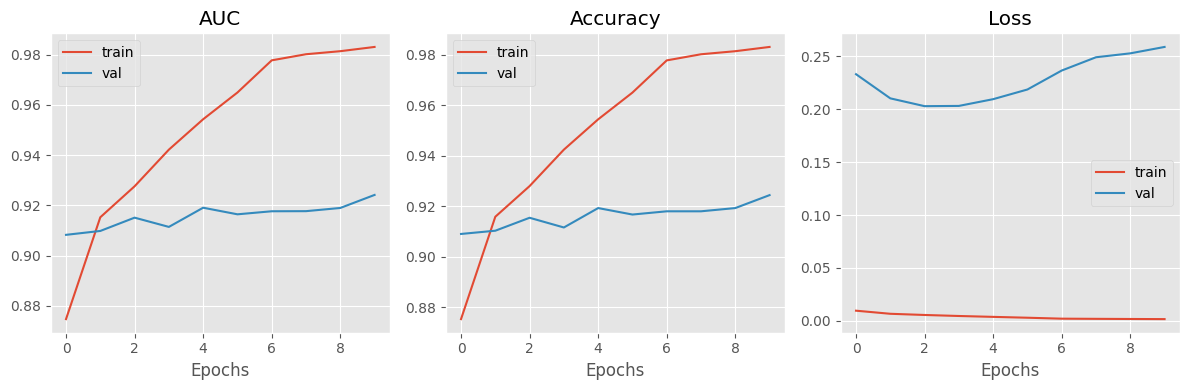

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(train_aucs, label='train')
axs[0].plot(val_aucs, label='val')
axs[0].set_xlabel('Epochs')
axs[0].set_title('AUC')
axs[0].legend()

axs[1].plot(train_accs, label='train')
axs[1].plot(val_accs, label='val')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend()

axs[2].plot(train_losses, label='train')
axs[2].plot(val_losses, label='val')
axs[2].set_xlabel('Epochs')
axs[2].set_title('Loss')
axs[2].legend()

plt.tight_layout()
plt.show()

In [15]:
# we want to predict the test set like this code:
predictions = trainer.predict()

print(classification_report(test["label"], predictions))
print("Accuracy:", accuracy_score(test["label"], predictions))
print("Precision:", precision_score(test["label"], predictions, average='weighted'))
print("Recall:", recall_score(test["label"], predictions, average='weighted'))



100%|██████████| 163/163 [00:02<00:00, 55.82it/s] 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2644
           1       0.91      0.95      0.93      2556

    accuracy                           0.93      5200
   macro avg       0.93      0.93      0.93      5200
weighted avg       0.93      0.93      0.93      5200

Accuracy: 0.9255769230769231
Precision: 0.926436141125201
Recall: 0.9255769230769231
